# LLama2 Experiment

In [3]:
from ctransformers import AutoModelForCausalLM
import time

# check ctransformers doc for more configs
config = {'max_new_tokens': 256, 'repetition_penalty': 1.1, 
          'temperature': 0.1, 'stream': True}

#model_id = "../models/llama-2-7b-chat.ggmlv3.q2_K.bin" # 17sec, 8sec
#model_id = "../models/llama-2-7b-chat.ggmlv3.q6_K.bin" # 36sec, 16sec
model_id = "../models/llama-2-7b-chat.ggmlv3.q8_0.bin" # 27sec, 22sec

llm = AutoModelForCausalLM.from_pretrained(
      model_id, 
      model_type="llama",                                           
      lib='avx2', 
      #gpu_layers=110,
      **config
      )

translation_prompt = """
    Translate the following text to English.
     Cher Tom,
     
     Nous avons discuté lors de la dernière réunion que nous réaliserions les 5 premières tâches et que nous en ferions 2 autres si nous en avions le temps. 
     La semaine prochaine, nous aurons un appel pour discuter du processus de validation.
     
     D'ici là, si vous avez d'autres questions, vous êtes libre de me contacter.

     Meilleures salutations,
     Christophe
    """

iteration_speed_llama2 = []
iteration_result_llama2 = []
for i in range(1, 101):
    print("Iteration: ",str(i))
    start = time.time()
    output = llm(translation_prompt, stream=False)

    time_generate = time.time() - start
    print(f'Time for complete generation: {time_generate}s')

    iteration_speed_llama2.append(time_generate)
    iteration_result_llama2.append(output)

### Storing the results

In [ ]:
llama2_result_text_length = []
for t in iteration_result_llama2:
    llama2_result_text_length.append(len(t))

In [ ]:
import pandas as pd
# Creating a DataFrame
df = pd.DataFrame({
    'Speed': iteration_speed_llama2,
    'Length': llama2_result_text_length,
    'Text': iteration_result_llama2
})

In [ ]:
df.to_csv("llama.csv",sep="|")

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(iteration_speed_llama2)

### Text Generation with LLama2

In [ ]:
prompt="""
Act as a data science expert. Write me 5 project ideas to create to get a job as a data scientit, in bullet list format.
"""
import time
start = time.time()

print(llm(prompt, stream=False))

time_generate = time.time() - start
print(f'Time for complete generation: {time_generate}s')

# Zepyhr Experiment

In [5]:
from ctransformers import AutoModelForCausalLM, AutoConfig, Config
import time

conf = AutoConfig(Config(temperature=0.7, repetition_penalty=1.1, batch_size=52,
                max_new_tokens=1024, context_length=2048))
llm2 = AutoModelForCausalLM.from_pretrained("../models/zephyr-7b-alpha.Q4_K_M.gguf",
                                           model_type="mistral", config = conf)

In [6]:
translation_prompt = """
Translate the following text to English.

Cher Tom,

Nous avons discuté lors de la dernière réunion que nous réaliserions les 5 premières tâches et que nous en ferions 2 autres si nous en avions le temps. 
La semaine prochaine, nous aurons un appel pour discuter du processus de validation.

D'ici là, si vous avez d'autres questions, vous êtes libre de me contacter.

Meilleures salutations,

Christophe
"""

In [ ]:
iteration_speed_zepyhr = []
iteration_result_zepyhr = []
for i in range(1, 101):
    print("Iteration: ",str(i))
    start_time = time.time()
    template = f'''<|system|>Translate the prompt to English
    </s>
    <|user|>
    {translation_prompt}</s>
    <|assistant|>
    '''
    output = llm2(template)
    time_generate = time.time() - start_time
    print("--- %s seconds ---" % (time_generate))
    iteration_speed_zepyhr.append(time_generate)
    iteration_result_zepyhr.append(output)

Iteration:  1
--- 44.17333197593689 seconds ---
Iteration:  2
--- 7.5453200340271 seconds ---
Iteration:  3


In [ ]:
zepyhr_result_text_length = []
for t in iteration_result_zepyhr:
    zepyhr_result_text_length.append(len(t))

### Storing the results

In [ ]:
import pandas as pd
# Creating a DataFrame
df = pd.DataFrame({
    'Speed': iteration_speed_zepyhr,
    'Length': zepyhr_result_text_length,
    'Text': iteration_result_zepyhr
})
df

In [ ]:
df.to_csv("zepyhr.csv",sep="|")

### Text Generation with Zepyhr

In [ ]:
prompt = "Write me 5 project ideas to create to get a job as a data scientit, in bullet list format."
start_time = time.time()
template = f'''<|system|> Act as a data science expert. 
</s> 
<|user|>
{prompt}</s>
<|assistant|>
'''
print(llm2(template))
print("--- %s seconds ---" % (time.time() - start_time))

# Analyse

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_llama = pd.read_csv("llama.csv",sep="|")
df_llama.drop(columns=['Unnamed: 0'], inplace=True)
print(df_llama.shape)
df_zepyhr = pd.read_csv("zepyhr.csv",sep="|")
df_zepyhr.drop(columns=['Unnamed: 0'], inplace=True)
print(df_zepyhr.shape)

(100, 3)
(100, 3)


In [3]:
print("Average speed (seconds) of Zepyhr: ",df_zepyhr['Speed_Zepyhr'].mean())
print("Average speed (seconds) of Llama: ",df_llama['Speed_Llama'].mean())

Average speed (seconds) of Zepyhr:  8.01265522480011
Average speed (seconds) of Llama:  15.45796451807022


In [8]:
df_both = pd.concat([df_llama, df_zepyhr], axis=1)
df_both.dtypes

Speed_Llama      float64
Length_Llama       int64
Text_Llama        object
Speed_Zepyhr     float64
Length_Zepyhr      int64
Text_Zepyhr       object
dtype: object

## Performance analysis

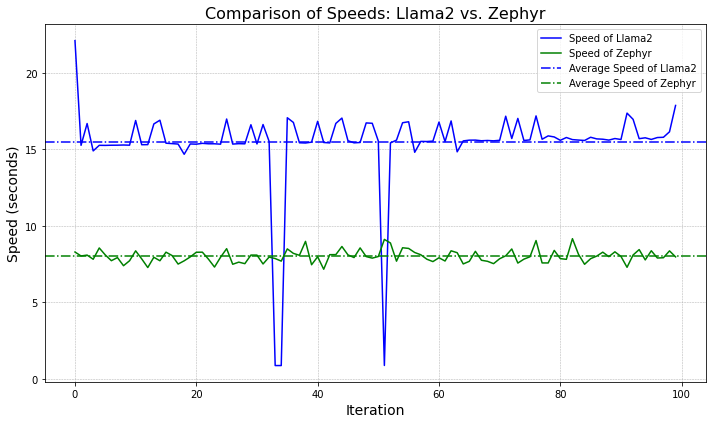

In [9]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with a custom color palette, line style, and marker
df_both['Speed_Llama'].plot(ax=ax, color='blue', linestyle='-', label='Speed of Llama2')
df_both['Speed_Zepyhr'].plot(ax=ax, color='green', linestyle='-',  label='Speed of Zephyr')

# Add average lines
avg_llama = df_both['Speed_Llama'].mean()
avg_zephyr = df_both['Speed_Zepyhr'].mean()

ax.axhline(avg_llama, color='blue', linestyle='-.', label='Average Speed of Llama2')
ax.axhline(avg_zephyr, color='green', linestyle='-.', label='Average Speed of Zephyr')


# Add title and labels
ax.set_title('Comparison of Speeds: Llama2 vs. Zephyr', fontsize=16)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Speed (seconds)', fontsize=14)

# Add a grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Consistency Analysis

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import language_tool_python

In [11]:
def analyze_consistency(texts):
    # Convert texts to TF-IDF vectors
    vectorizer = TfidfVectorizer().fit_transform(texts)
    
    # Compute cosine similarity for all pairs of texts
    cosine_matrix = cosine_similarity(vectorizer)
    
    # Since the diagonal will always be 1 (text compared to itself), 
    # we exclude it to get a more meaningful average similarity
    np.fill_diagonal(cosine_matrix, 1)
    
    # Return average similarity
    avg_similarity = np.nanmean(cosine_matrix)
    return avg_similarity


In [12]:
df_both[:35]

,Speed_Llama,Length_Llama,Text_Llama,Speed_Zepyhr,Length_Zepyhr,Text_Zepyhr
0,22.110595,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",8.295529,294,"\nDear Tom,\n\nWe discussed during our last me..."
1,15.268856,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",8.036292,281,"\nDear Tom,\n\nDuring our last meeting, we dec..."
2,16.692148,387,\n\nThe text is in French and it can be transl...,8.094346,290,"\nDear Tom,\n\nWe discussed during our last me..."
3,14.903525,344,"\n\n Translation:\n\n Dear Tom,\n\n W...",7.822113,280,"\nDear Tom,\n\nAt the last meeting we discusse..."
4,15.268856,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",8.559615,304,"\nDear Tom,\n\nDuring our last meeting, we dis..."
5,15.264853,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",8.101863,287,"\nDear Tom,\n\nDuring our last meeting, we dis..."
6,15.274862,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",7.728013,281,"\nDear Tom,\n\nDuring our last meeting, we dis..."
7,15.277864,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",7.932199,299,"\nDear Tom,\n\nWe discussed during our last me..."
8,15.288877,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",7.399714,277,"\nDear Tom,\n\nDuring our last meeting, we dis..."
9,15.277863,350,"\n\n Translation:\n\n Dear Tom,\n\n W...",7.725010,291,"\nDear Tom,\n\nWe discussed during our last me..."


### Consistency check of LLama2

In [13]:
texts = df_both[:40]['Text_Llama'].values
consistency_score = analyze_consistency(texts)
print(f"Average Llama2 Consistency Score (Cosine Similarity): {consistency_score:.2f}")

Average Llama2 Consistency Score (Cosine Similarity): 0.82


### Consistency check of Zepyhr

In [14]:
texts = df_both['Text_Zepyhr'].values
consistency_score = analyze_consistency(texts)
print(f"Average Zepyhr Consistency Score (Cosine Similarity): {consistency_score:.2f}")

Average Zepyhr Consistency Score (Cosine Similarity): 0.69


In [15]:
TfidfVectorizer().fit_transform(texts)

<100x107 sparse matrix of type '<class 'numpy.float64'>'
	with 4275 stored elements in Compressed Sparse Row format>

## Human evaluation

In [16]:
df_both.sample(5)['Text_Llama'].values

array(['\n\n    Translation:\n\n    Dear Tom,\n\n    We discussed during the last meeting that we would complete the first five tasks and potentially add two more if we had time. Next week, we will have a call to discuss the validation process.\n\n    Until then, feel free to reach out to me with any other questions you may have.\n\n    Best regards,\n\n    Christophe',
       '\n\n    Translation:\n\n    Dear Tom,\n\n    We discussed during the last meeting that we would complete the first five tasks and potentially add two more if we had time. Next week, we will have a call to discuss the validation process.\n\n    Until then, feel free to reach out to me with any other questions you may have.\n\n    Best regards,\n\n    Christophe',
       '\n\n    Translation:\n\n    Dear Tom,\n\n    We discussed during the last meeting that we would complete the first five tasks and potentially add two more if we had time. Next week, we will have a call to discuss the validation process.\n\n    Un

In [17]:
df_both.sample(5)['Text_Zepyhr'].values

array(['\nDear Tom,\n\nDuring the last meeting we decided that we will execute the first five tasks and complete two more if time permits. Next week, we will have a call to discuss the validation process. If you have any other questions, please do not hesitate to contact me. Best regards,\n\nChristophe',
       "\nDear Tom,\n\nAs previously discussed in the last meeting, we will complete the first five tasks and two more if time permits. Next week, we'll have a call to discuss the validation process. If you have any other questions, feel free to contact me. Best regards,\n\nChristophe",
       '\nDear Tom,\n\nDuring the last meeting we agreed that we will complete the first five tasks and if time permits, we will do two more. Next week we will have a call to discuss the validation process. If you have any other questions please do not hesitate to contact me.\n\nBest regards,\n\nChristophe',
       "\nDear Tom,\n\nDuring our last meeting, we discussed that we would complete the first fi

## METEOR SCORE

In [59]:
from nltk.translate.meteor_score import meteor_score

def pairwise_comparison(phrases):
    n = len(phrases)
    matrix = [[0 for _ in range(n)] for _ in range(n)]
    
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i][j] = meteor_score([phrases[i].split()], phrases[j].split())
                
    return matrix


In [62]:
matrix = pairwise_comparison(df_both['Text_Llama'].values)
means_llama2 = []
for row in matrix:
    means_llama2.append(np.mean(row))
print("Average score for Llama2", np.mean(means_llama2))

Average score for Llama2 0.887944054420998


In [61]:
matrix = pairwise_comparison(df_both['Text_Zepyhr'].values)
means_zephyr = []
for row in matrix:
    means_zephyr.append(np.mean(row))
print("Average score for Zephyr", np.mean(means_zephyr))

Average score for Zephyr 0.848645993985023
